<a href="https://colab.research.google.com/github/tomasdevelopment/PuckInsights/blob/main/notebooks/sportsstatistics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [32]:
#Exploratory analysis
import pandas as pd

# ------------------------------------------------------------------ #
# 0.  Load raw data                                                  #
# ------------------------------------------------------------------ #
FILE_PATH = "/content/drive/My Drive/sportsanalytics/nhldraft.csv"
hockey_df = pd.read_csv(FILE_PATH)

# ------------------------------------------------------------------ #
# 1.  Clean function (must exist BEFORE using it)                    #
# ------------------------------------------------------------------ #
def clean_hockey_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()         # Clean column names
    df.dropna(how='all', inplace=True)          # Drop empty rows

    # Make sure 'points' exists and is numeric, then fill NaNs
    if 'points' in df.columns:
        df['points'] = pd.to_numeric(df['points'], errors='coerce').fillna(0).astype(int)
    else:
        raise KeyError("'points' column not found in DataFrame")
    return df

# ------------------------------------------------------------------ #
# 2.  Clean, but DO NOT overwrite the function!                      #
# ------------------------------------------------------------------ #
hockey_clean = clean_hockey_df(hockey_df)   # ← keep object & function distinct

# ------------------------------------------------------------------ #
# 3.  One-liner footprint helper                                     #
# ------------------------------------------------------------------ #
def footprint(df: pd.DataFrame) -> dict:
    """Return shape & memory stats for any DataFrame."""
    mem_bytes = df.memory_usage(deep=True).sum()
    return {
        "rows"          : len(df),
        "cols"          : df.shape[1],
        "memory_MB"     : round(mem_bytes / 1024 ** 2, 3),
        "bytes_per_row" : round(mem_bytes / len(df), 1) if len(df) else 0,
        "min_year": df.year.min(),
        "max_year": df.year.max(),
    }

print("After cleaning:")
for k, v in footprint(hockey_clean).items():
    print(f"  {k:>13}: {v}")

# ------------------------------------------------------------------ #
# 4.  Optional peek                                                  #
# ------------------------------------------------------------------ #
print(hockey_clean.head())
hockey_clean.columns

After cleaning:
           rows: 12250
           cols: 23
      memory_MB: 5.67
  bytes_per_row: 485.3
       min_year: 1963
       max_year: 2022
   id  year  overall_pick                 team            player nationality  \
0   1  2022             1   Montreal Canadiens  Juraj Slafkovsky          SK   
1   2  2022             2    New Jersey Devils       Simon Nemec          SK   
2   3  2022             3      Arizona Coyotes      Logan Cooley          US   
3   4  2022             4       Seattle Kraken      Shane Wright          CA   
4   5  2022             5  Philadelphia Flyers   Cutter Gauthier          SE   

  position   age  to_year                           amateur_team  ...  points  \
0       LW  18.0      NaN                          TPS (Finland)  ...       0   
1        D  18.0      NaN                    HK Nitra (Slovakia)  ...       0   
2        C  18.0      NaN  USA U-18 Development Team (USDP/USHL)  ...       0   
3        C  18.0      NaN              Kingston

Index(['id', 'year', 'overall_pick', 'team', 'player', 'nationality',
       'position', 'age', 'to_year', 'amateur_team', 'games_played', 'goals',
       'assists', 'points', 'plus_minus', 'penalties_minutes',
       'goalie_games_played', 'goalie_wins', 'goalie_losses',
       'goalie_ties_overtime', 'save_percentage', 'goals_against_average',
       'point_shares'],
      dtype='object')

In [49]:
#Exploratory analysis One
import pandas as pd
from scipy import stats
from typing import Dict, List, Tuple

# --------------------------------------------------------------------------- #
# 1.  Cleaning layer (unchanged from last fix)                                #
# --------------------------------------------------------------------------- #
def clean_hockey_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = df.columns.str.strip()
    df.dropna(how='all', inplace=True)

    # points → numeric, NaN→0, cast to int
    if 'points' not in df.columns:
        raise KeyError("'points' column not found")
    df['points'] = (
        pd.to_numeric(df['points'], errors='coerce')
        .fillna(0)
        .astype(int)
    )
    return df


# --------------------------------------------------------------------------- #
# 2A.  Summary-only helper                                                    #
# --------------------------------------------------------------------------- #
def points_summary(
    pts: pd.Series, *, trim_prop: float = 0.10
) -> Dict[str, float | int]:
    """
    Return location & dispersion stats for a points Series.
    """
    q1, q3 = pts.quantile([0.25, 0.75])
    iqr = q3 - q1
    return {
        "count"        : int(pts.count()),
        "mean"         : float(pts.mean()),
        "median"       : int(pts.median()),
        "trimmed_mean" : float(stats.trim_mean(pts, trim_prop)),
        "mad"          : float(stats.median_abs_deviation(pts, scale="normal")),
        "variance"     : float(pts.var()),
        "std_dev"      : float(pts.std()),
        "iqr"          : int(iqr),
        "lower_bound"  : int(q1 - 1.5 * iqr),
        "upper_bound"  : int(q3 + 1.5 * iqr),
    }


# --------------------------------------------------------------------------- #
# 2B.  Group-slices helper                                                    #
# --------------------------------------------------------------------------- #
def points_groups(
    df_clean: pd.DataFrame,
    summary: Dict[str, float | int],
) -> Dict[str, List[dict]]:
    """
    Return dict of interesting player slices, already sorted.
    """
    pts = df_clean["points"]

    def keep_cols(df: pd.DataFrame) -> List[dict]:
        return df[["year", "player", "team", "points"]].to_dict("records")

    upper = df_clean[pts >= summary["upper_bound"]]\
            .sort_values(["year", "points"], ascending=False)

    lower = df_clean[pts <= summary["lower_bound"]]\
            .sort_values(["points", "year"], ascending=True)

    max_pts, min_pts = int(pts.max()), int(pts.min())

    return {
        "upper_players"   : keep_cols(upper),
        "lower_players"   : keep_cols(lower),
        "top_players"     : keep_cols(df_clean[pts == max_pts]),
        "bottom_players"  : keep_cols(df_clean[pts == min_pts]),
        "bottom_nonzero"  : keep_cols(df_clean[pts == pts[pts != 0].min()])
                            if (pts != 0).any() else [],
    }


# --------------------------------------------------------------------------- #
# 3.  Public façade — returns *two* objects                                   #
# --------------------------------------------------------------------------- #
def hockey_overview(
    df: pd.DataFrame, *, trim_prop: float = 0.10
) -> Tuple[Dict[str, float | int], Dict[str, List[dict]]]:
    """
    High-level wrapper that returns (summary, groups).
    """
    df_clean = clean_hockey_df(df)
    pts      = df_clean["points"]
    summary  = points_summary(pts, trim_prop=trim_prop)
    groups   = points_groups(df_clean, summary)
    return summary, groups


# --------------------------------------------------------------------------- #
# Example usage                                                               #
# --------------------------------------------------------------------------- #
FILE_PATH = "/content/drive/My Drive/sportsanalytics/nhldraft.csv"
raw_df     = pd.read_csv(FILE_PATH)

summary_dict, groups_dict = hockey_overview(hockey_clean)

print("== Location & dispersion statistics ==")
for k, v in summary_dict.items():
    print(f"{k:>14}: {v}")

print("\n== Upper-outlier players ==")
for rec in groups_dict["upper_players"][:5]:  # show first 5 only
    print(rec)




== Location & dispersion statistics ==
         count: 12250
          mean: 58.19697959183674
        median: 0
  trimmed_mean: 14.069591836734693
           mad: 0.0
      variance: 27733.15843646375
       std_dev: 166.5327548455971
           iqr: 14
   lower_bound: -21
   upper_bound: 35

== Upper-outlier players ==
{'year': 2020, 'player': 'Tim Stützle', 'team': 'Ottawa Senators', 'points': 87}
{'year': 2020, 'player': 'Lucas Raymond', 'team': 'Detroit Red Wings', 'points': 57}
{'year': 2020, 'player': 'Alexis Lafreniere', 'team': 'New York Rangers', 'points': 52}
{'year': 2020, 'player': 'Anton Lundell', 'team': 'Florida Panthers', 'points': 44}
{'year': 2020, 'player': 'Dawson Mercer', 'team': 'New Jersey Devils', 'points': 42}


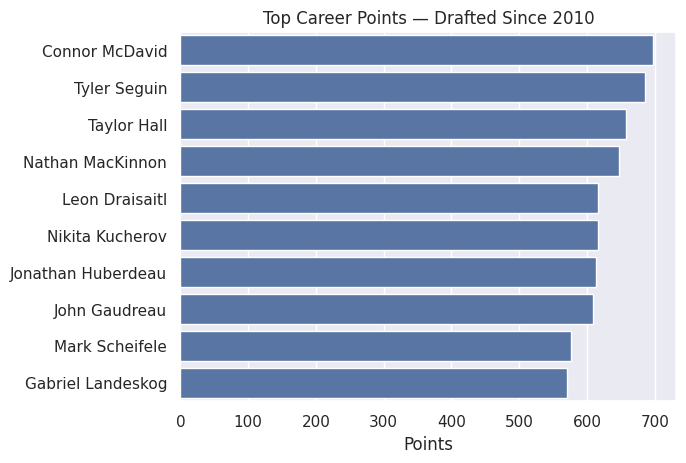

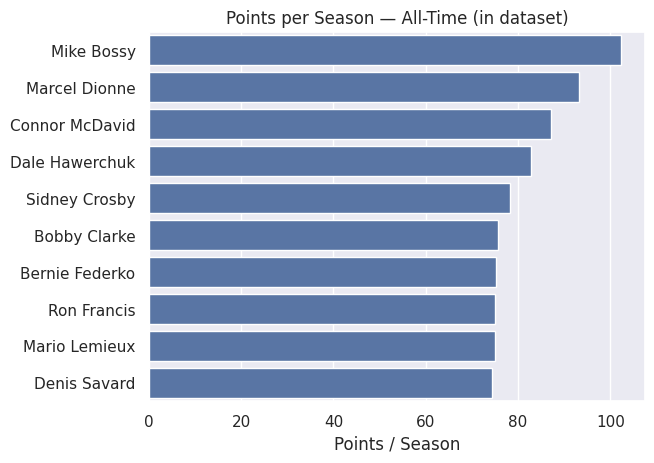

In [58]:
#Mcdavid Analytics
# Filter recent draft years
recent_players = hockey_clean[hockey_clean["year"] >= 2010].copy()

# Sort by career points in dataset
top_recent = recent_players.sort_values("points", ascending=False).head(10)

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(data=top_recent, x="points", y="player")
plt.title("Top Career Points — Drafted Since 2010")
plt.xlabel("Points")
plt.ylabel("")
plt.show()


hockey_clean["years_played"] = hockey_clean["to_year"] - hockey_clean["year"] + 1
hockey_clean["points_per_season"] = hockey_clean["points"] / hockey_clean["years_played"]

top_rate = (
    hockey_clean[hockey_clean["points"] > 0]
    .sort_values("points_per_season", ascending=False)
    .head(10)
)

sns.barplot(data=top_rate, x="points_per_season", y="player")
plt.title("Points per Season — All-Time (in dataset)")
plt.xlabel("Points / Season")
plt.ylabel("")
plt.show()




Season points — location stats by cohort:
cohort  mean_points  median_points  count
 <2000        71.15            0.0   6929
 ≥2000        41.33            0.0   5321


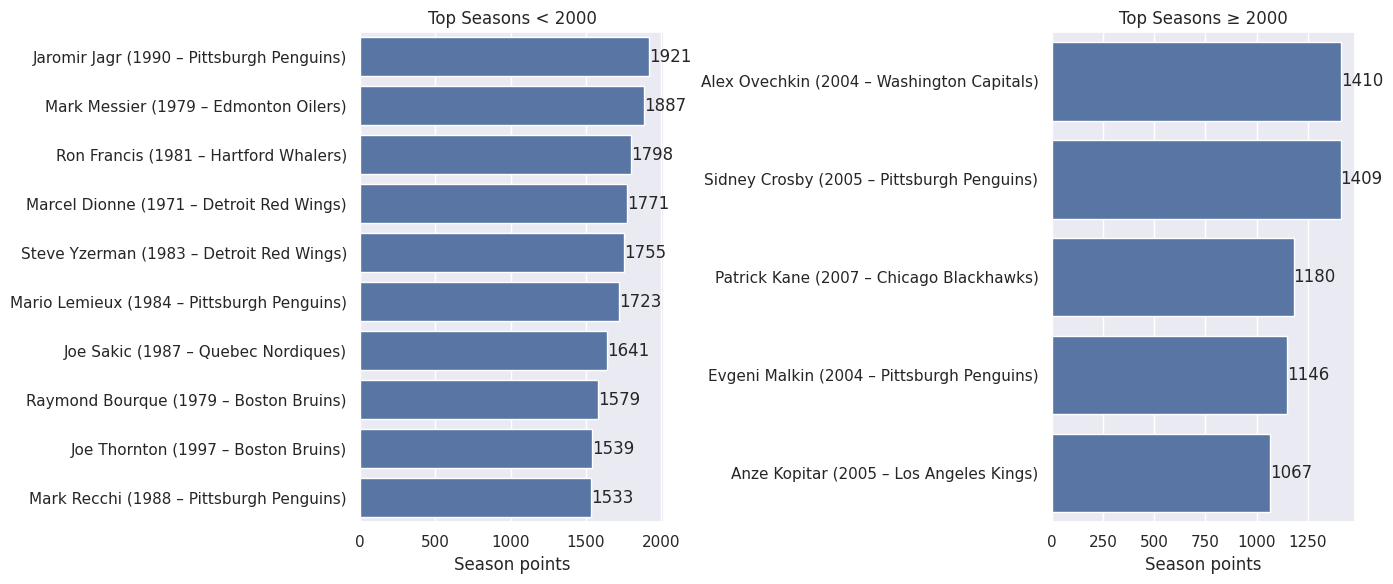

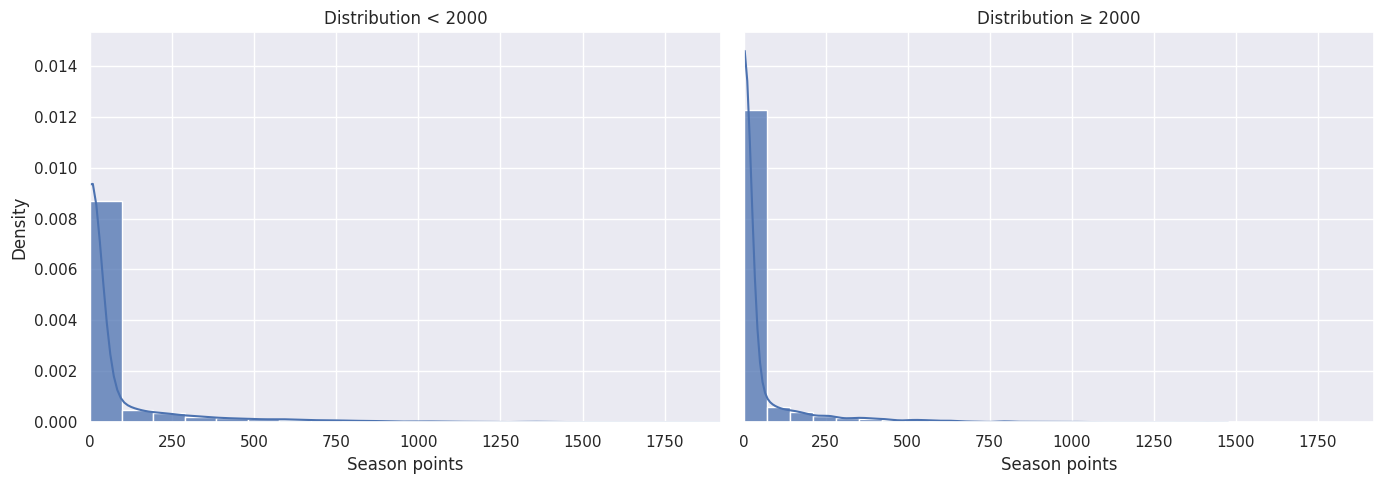

,player,team,year,points
3865,Alex Ovechkin,Washington Capitals,2004,1410
3635,Sidney Crosby,Pittsburgh Penguins,2005,1409
3211,Patrick Kane,Chicago Blackhawks,2007,1180
3866,Evgeni Malkin,Pittsburgh Penguins,2004,1146
3645,Anze Kopitar,Los Angeles Kings,2005,1067


In [55]:
#
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def _ensure_numeric(df, col):
    out = df.copy()
    out[col] = pd.to_numeric(out[col], errors="coerce")
    return out.dropna(subset=[col])

def season_comparison_simple(
    df,
    *,
    cutoff_year=2000,
    top_before=10,
    top_after=5,
    bins=20
):
    """
    Season-based comparison: pre-2000 vs >=2000.
    Makes at most 4 plots (2 bars + 2 distributions) and prints mean/median per cohort.
    """
    req = {"year", "player", "team", "points"}
    miss = req - set(df.columns)
    if miss:
        raise KeyError(f"Missing columns: {miss}")

    df = _ensure_numeric(df, "points")
    df = _ensure_numeric(df, "year")

    # Split cohorts (season-based)
    pre = df[df["year"] < cutoff_year].copy()
    post = df[df["year"] >= cutoff_year].copy()

    # Top seasons per cohort
    top_pre  = (pre.sort_values("points", ascending=False)
                   .head(top_before)
                   .assign(cohort=f"<{cutoff_year} (top {top_before})"))
    top_post = (post.sort_values("points", ascending=False)
                   .head(top_after)
                   .assign(cohort=f"≥{cutoff_year} (top {top_after})"))

    # Nice labels: "Player (Year – Team)"
    top_pre["label"]  = top_pre.apply(lambda r: f"{r.player} ({int(r.year)} – {r.team})", axis=1)
    top_post["label"] = top_post.apply(lambda r: f"{r.player} ({int(r.year)} – {r.team})", axis=1)

    # ---- Stats (location only, keep it simple) ----
    stats = (
        pd.concat([
            pre.assign(cohort=f"<{cutoff_year}"),
            post.assign(cohort=f"≥{cutoff_year}")
        ])[["cohort", "points"]]
         .groupby("cohort")
         .agg(mean_points=("points", "mean"),
              median_points=("points", "median"),
              count=("points", "count"))
         .round(2)
         .reset_index()
    )
    print("Season points — location stats by cohort:")
    print(stats.to_string(index=False))

    # ---- Shared x-limits for fair distribution comparison ----
    xmin = df["points"].min()
    xmax = df["points"].max()

    sns.set_theme()

    # ========== FIGURE 1: Top seasons (2 bar charts) ==========
    fig1, axes1 = plt.subplots(1, 2, figsize=(14, 6), sharex=False, sharey=False)
    # Pre-2000 bars
    ax = axes1[0]
    sns.barplot(data=top_pre, x="points", y="label", ax=ax)
    ax.set_title(f"Top Seasons < {cutoff_year}")
    ax.set_xlabel("Season points")
    ax.set_ylabel("")
    for c in ax.containers:
        ax.bar_label(c, fmt="%.0f")

    # Post-2000 bars
    ax = axes1[1]
    sns.barplot(data=top_post, x="points", y="label", ax=ax)
    ax.set_title(f"Top Seasons ≥ {cutoff_year}")
    ax.set_xlabel("Season points")
    ax.set_ylabel("")
    for c in ax.containers:
        ax.bar_label(c, fmt="%.0f")

    fig1.tight_layout()
    plt.show()

    # ========== FIGURE 2: Distributions (2 panels) ==========
    fig2, axes2 = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)
    # Pre
    ax = axes2[0]
    sns.histplot(pre["points"], bins=bins, stat="density", ax=ax)
    try:
        sns.kdeplot(pre["points"], ax=ax)
    except Exception:
        pass
    ax.set_title(f"Distribution < {cutoff_year}")
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Season points")
    ax.set_ylabel("Density")

    # Post
    ax = axes2[1]
    sns.histplot(post["points"], bins=bins, stat="density", ax=ax)
    try:
        sns.kdeplot(post["points"], ax=ax)
    except Exception:
        pass
    ax.set_title(f"Distribution ≥ {cutoff_year}")
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel("Season points")
    ax.set_ylabel("")

    fig2.tight_layout()
    plt.show()

    return {
        "stats": stats,
        "top_pre": top_pre[["player","team","year","points"]],
        "top_post": top_post[["player","team","year","points"]],
    }
out = season_comparison_simple(hockey_clean, cutoff_year=2000, top_before=10, top_after=5)
out["stats"]        # mean/median per cohort
out["top_pre"]      # top-10 seasons before 2000
out["top_post"]     # top-5 seasons since 2000


Season points — location stats by cohort:
cohort  mean_points  median_points  count
 <2000        71.15            0.0   6929
 ≥2000        41.33            0.0   5321


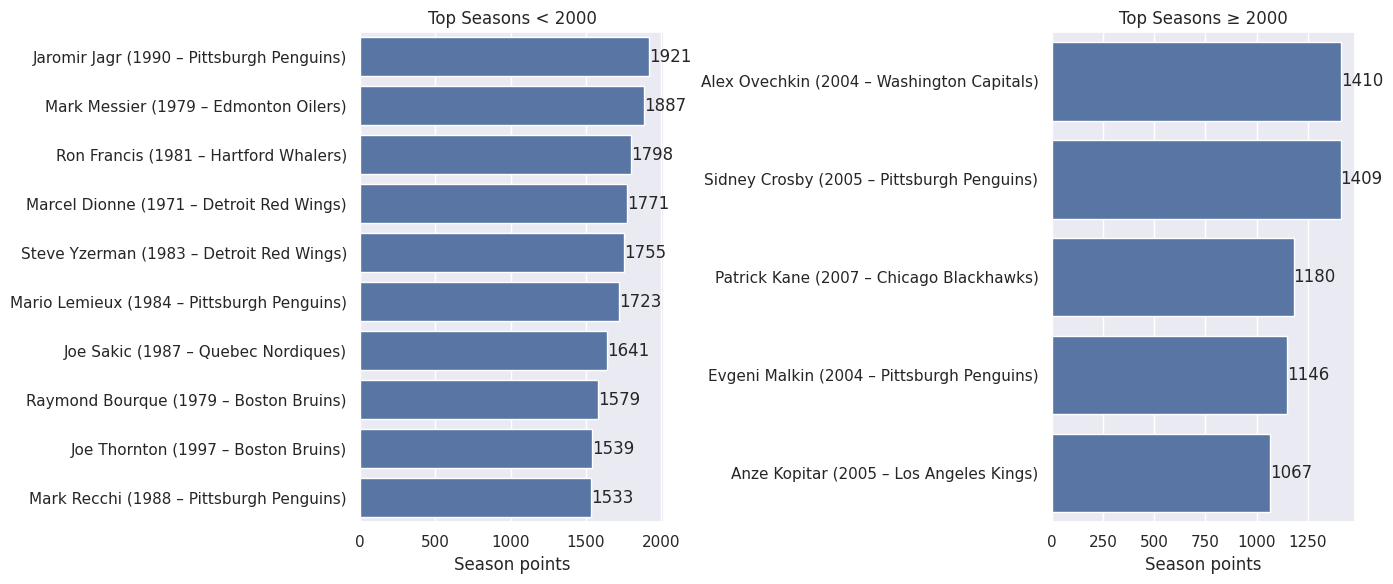

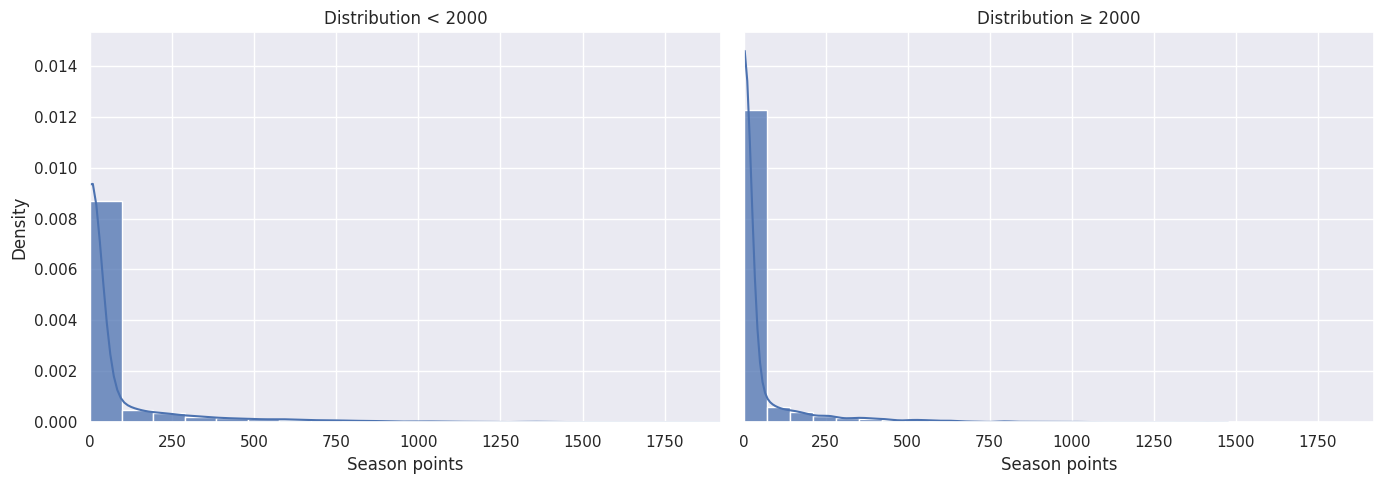

,player,team,year,points
3865,Alex Ovechkin,Washington Capitals,2004,1410
3635,Sidney Crosby,Pittsburgh Penguins,2005,1409
3211,Patrick Kane,Chicago Blackhawks,2007,1180
3866,Evgeni Malkin,Pittsburgh Penguins,2004,1146
3645,Anze Kopitar,Los Angeles Kings,2005,1067


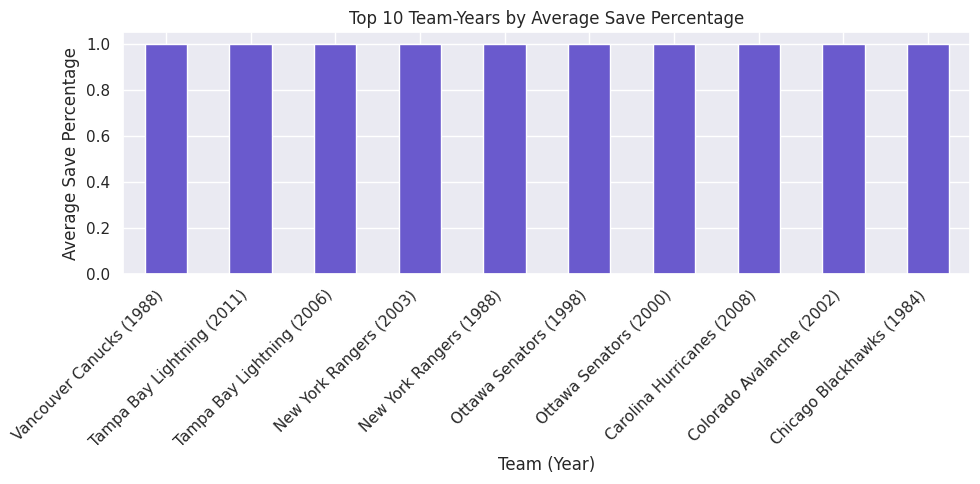

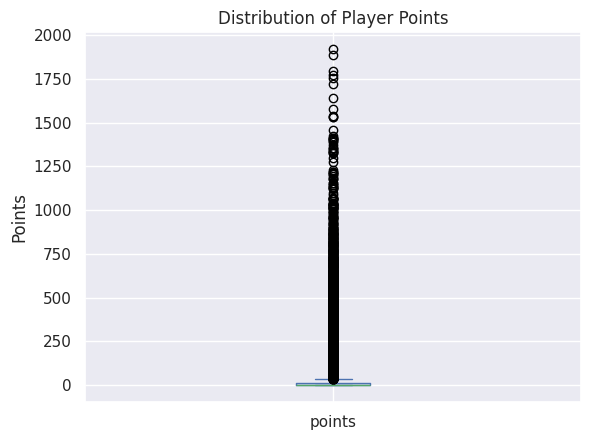

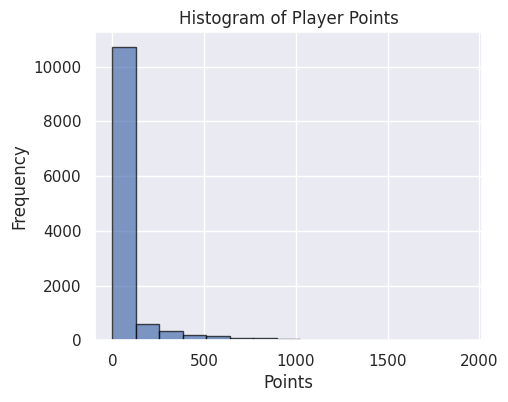

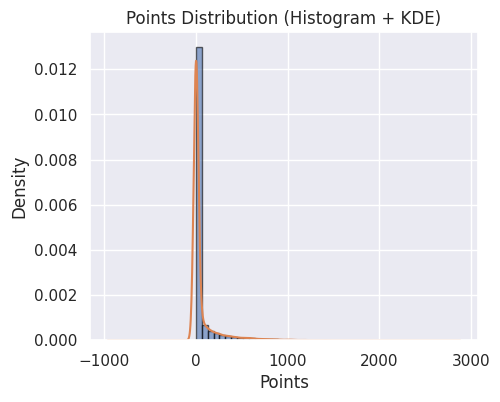

<Axes: title={'center': 'Points Distribution (Histogram + KDE)'}, xlabel='Points', ylabel='Density'>

In [59]:
#exploratory analysis analytics
import matplotlib.pyplot as plt
import pandas as pd      # ←-- make sure this is imported if you call binned_points_distribution

# ──────────────────────────────────────────────────────────────────────────────
# ▶ BOTH (location + spread)  — quantiles include the median (center) and tails
def points_percentiles(df, col='points', percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]):
    """
    Returns specified percentiles for the points column in the DataFrame.

    Statistic type
    --------------
    • 5-th/25-th/75-th/95-th  → spread
    • 50-th (median)         → location
    """
    return df[col].quantile(percentiles)

# ──────────────────────────────────────────────────────────────────────────────
# ▶ BOTH (location + spread)  — median line = location, box/IQR & whiskers = spread
def plot_points_box(df, col='points', title='Distribution of Player Points'):
    """
    Plots a box plot for the points column.

    Statistic type
    --------------
    • Median line            → location
    • IQR & whiskers         → spread
    """
    ax = df[col].plot.box()
    ax.set_ylabel('Points')
    ax.set_title(title)
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# ▶ SPREAD  — shape/width show dispersion; center is secondary
def plot_points_hist(df, col='points', bins=15, title='Histogram of Player Points'):
    """
    Plots a histogram for the points column.

    Statistic type
    --------------
    • Bar width & silhouette → spread (variance, skew)
    """
    ax = df[col].plot.hist(bins=bins, figsize=(5, 4),
                           alpha=0.7, edgecolor='black')
    ax.set_xlabel('Points')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# ▶ SPREAD  — same information as a histogram but returned as counts per bin
def binned_points_distribution(df, col='points', bins=10):
    """
    Returns value counts for points binned into intervals.

    Statistic type
    --------------
    • Count per interval     → spread (distribution profile)
    """
    binned = pd.cut(df[col], bins=bins)
    return binned.value_counts().sort_index()

# ──────────────────────────────────────────────────────────────────────────────
# ▶ SPREAD  — histogram + smooth KDE visualise dispersion/shape
def plot_points_hist_kde(df, col='points', bins=30,
                         title='Points Distribution (Histogram + KDE)'):
    """
    Plots a histogram with density=True and overlays a KDE for the points column.

    Statistic type
    --------------
    • Histogram & KDE curve  → spread (variance, multimodality, tails)
    """
    ax = df[col].plot.hist(density=True, bins=bins,
                           alpha=0.6, edgecolor='black',
                           figsize=(5, 4))
    df[col].plot.density(ax=ax)
    ax.set_xlabel('Points')
    ax.set_ylabel('Density')
    ax.set_title(title)
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# ▶ LOCATION  — bar height is the mean save-percentage per team-year
def plot_top_save_pct_teams_year(df, col_team='team', col_save='save_percentage',
                                 col_year='year', top_n=10):
    """
    Plots a bar chart of the top-N (team, year) pairs by average save percentage.

    Statistic type
    --------------
    • Mean save-percentage   → location (no spread shown unless error bars added)
    """
    subset = df[[col_team, col_save, col_year]].copy()
    subset[col_save] = pd.to_numeric(subset[col_save], errors='coerce')
    subset = subset.dropna(subset=[col_save, col_team, col_year])

    # Compute mean save % for every (team, year) combo
    group_avg = (subset
                 .groupby([col_team, col_year])[col_save]
                 .mean()
                 .sort_values(ascending=False))
    top_group = group_avg.head(top_n)

    # Human-friendly x-tick labels: "Team (Year)"
    labels = [f"{team} ({year})" for (team, year) in top_group.index]

    ax = top_group.plot.bar(figsize=(10, 5), color='slateblue', legend=False)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_xlabel('Team (Year)')
    ax.set_ylabel('Average Save Percentage')
    ax.set_title(f'Top {top_n} Team-Years by Average Save Percentage')
    plt.tight_layout()
    plt.show()
    return ax

# ──────────────────────────────────────────────────────────────────────────────
# Example usage (uncomment to run):
plot_top_save_pct_teams_year(hockey_clean)
points_percentiles(hockey_clean)
plot_points_box(hockey_clean)
plot_points_hist(hockey_clean)
plot_points_hist_kde(hockey_clean)


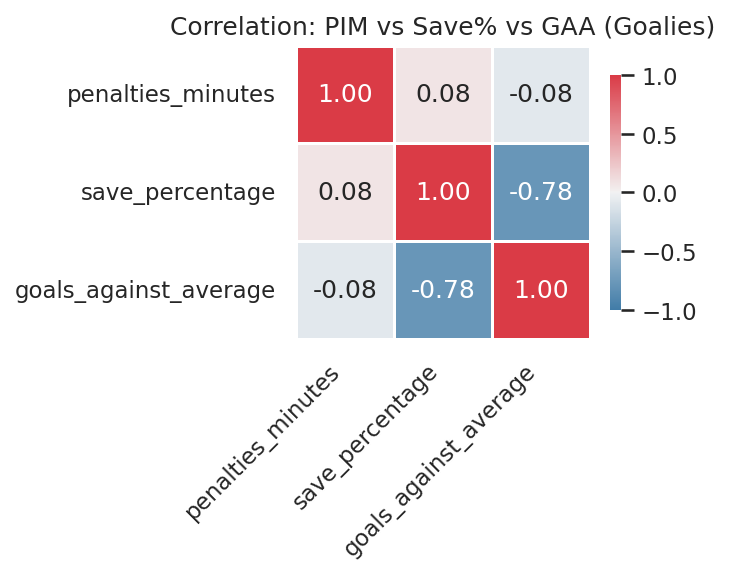

In [61]:
#Corelation analysis, still in process
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ---- columns of interest
maybe_goal_pct_col = "save_percentage"  # change to "goal_percentage" if you really have that
cols = ["penalties_minutes", maybe_goal_pct_col, "goals_against_average"]

gdf = hockey_df.copy()

# ---- filter to goalies (use whichever criterion your data supports)
if "position" in gdf.columns:
    gdf = gdf[gdf["position"].str.upper() == "G"]
elif "goalie_games_played" in gdf.columns:
    gdf = gdf[gdf["goalie_games_played"].fillna(0) > 0]

# ---- coerce penalties_minutes
if "penalties_minutes" in gdf.columns:
    gdf["penalties_minutes"] = pd.to_numeric(gdf["penalties_minutes"], errors="coerce")

# ---- coerce goals_against_average
if "goals_against_average" in gdf.columns:
    gdf["goals_against_average"] = pd.to_numeric(gdf["goals_against_average"], errors="coerce")

# ---- coerce save/goal percentage
if maybe_goal_pct_col in gdf.columns:
    sp = gdf[maybe_goal_pct_col].astype(str).str.replace("%", "", regex=False)
    sp = pd.to_numeric(sp, errors="coerce")
    # if most values are > 1, assume 0–100 scale and convert to 0–1
    if (sp.dropna() > 1).mean() > 0.5:
        sp = sp / 100.0
    gdf[maybe_goal_pct_col] = sp

# ---- drop rows missing any of the variables
present_cols = [c for c in cols if c in gdf.columns]
gdf = gdf.dropna(subset=present_cols)

# ---- compute correlations (Pearson). Try 'spearman' as a robustness check.
corr = gdf[present_cols].corr(method="pearson")

# ---- heatmap with diverging palette centered at 0
plt.figure(figsize=(5, 4), dpi=150)
ax = sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    cmap=sns.diverging_palette(240, 10, as_cmap=True),
    vmin=-1, vmax=1, center=0,
    square=True, linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
ax.set_title("Correlation: PIM vs Save% vs GAA (Goalies)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()


In [62]:
#In process PAIRWISE EPEARSON CORELATION If two variables are highly correlated (|r| > ~0.7, and p < 0.05)
from scipy.stats import pearsonr
import itertools as it

pairs = [("penalties_minutes","save_percentage"),
         ("penalties_minutes","goals_against_average"),
         ("save_percentage","goals_against_average")]

for a,b in pairs:
    sub = gdf[[a,b]].dropna()
    r,p = pearsonr(sub[a], sub[b])
    print(f"{a} vs {b}: r={r:.3f}, p={p:.3g}, n={len(sub)}")


penalties_minutes vs save_percentage: r=0.076, p=0.0938, n=488
penalties_minutes vs goals_against_average: r=-0.078, p=0.0838, n=488
save_percentage vs goals_against_average: r=-0.777, p=8.54e-100, n=488


Pairwise Pearson (sorted by |r|):
                var_a                 var_b         r             p   n
      save_percentage goals_against_average -0.777116 8.539282e-100 488
      save_percentage    point_shares_per82  0.667694  2.759679e-64 488
goals_against_average    point_shares_per82 -0.552569  1.609312e-40 490
             wins_pct    point_shares_per82  0.546104  7.056340e-36 444
goals_against_average              wins_pct -0.502336  9.196504e-30 444
      save_percentage              wins_pct  0.468504  1.317488e-25 444
             wins_pct          overall_pick -0.122271  9.913707e-03 444
   point_shares_per82          overall_pick -0.114341  1.131258e-02 490
             wins_pct          pim_per_game -0.060845  2.006631e-01 444
      save_percentage          pim_per_game -0.040527  3.716723e-01 488
goals_against_average          overall_pick  0.025800  5.688459e-01 490
         pim_per_game          overall_pick  0.022337  6.218311e-01 490
   point_shares_per82         

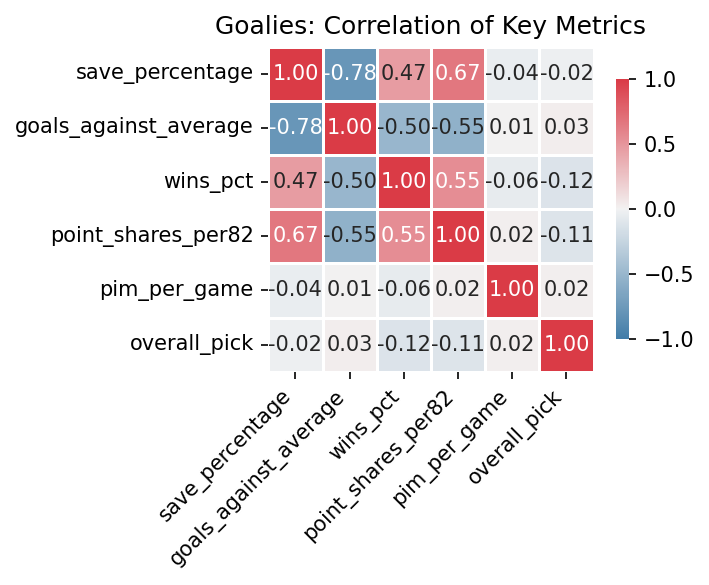

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from itertools import combinations
import seaborn as sns
import matplotlib.pyplot as plt

# -------- helpers
def to_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def to_pct01(s: pd.Series) -> pd.Series:
    s2 = s.astype(str).str.replace("%", "", regex=False)
    s2 = pd.to_numeric(s2, errors="coerce")
    # If typical value > 1, assume 0–100 scale and convert
    if s2.dropna().median() > 1:
        s2 = s2 / 100.0
    return s2

def ratio(num, den):
    out = num / den.replace(0, np.nan)
    return out

def pearson_pairs(df, cols, min_n=30):
    rows = []
    for a, b in combinations(cols, 2):
        sub = df[[a, b]].dropna()
        n = len(sub)
        if n < min_n:
            continue
        r, p = pearsonr(sub[a], sub[b])
        rows.append({"var_a": a, "var_b": b, "r": r, "p": p, "n": n})
    res = pd.DataFrame(rows).sort_values(by="r", key=lambda x: x.abs(), ascending=False)
    return res

# -------- start
gdf = hockey_df.copy()

# --- filter to goalies
if "position" in gdf.columns:
    gdf = gdf[gdf["position"].astype(str).str.upper() == "G"]
elif "goalie_games_played" in gdf.columns:
    gdf = gdf[gdf["goalie_games_played"].fillna(0) > 0]

# --- identify likely save% column
sv_candidates = ["save_percentage", "sv%", "SV%", "goal_percentage"]
sv_col = next((c for c in sv_candidates if c in gdf.columns), None)

# --- numeric coercions
numeric_cols = [
    "goals_against_average", "penalties_minutes",
    "goalie_games_played", "goalie_wins", "goalie_losses",
    "goalie_ties_overtime", "point_shares", "overall_pick"
]
gdf = to_numeric(gdf, numeric_cols)
if sv_col:
    gdf[sv_col] = to_pct01(gdf[sv_col])

# --- engineered features (goalies)
gdf["decisions"] = gdf[["goalie_wins", "goalie_losses", "goalie_ties_overtime"]].fillna(0).sum(axis=1)
gdf["wins_pct"] = ratio(gdf["goalie_wins"], gdf["decisions"])
gdf["pim_per_game"] = ratio(gdf["penalties_minutes"], gdf["goalie_games_played"])
gdf["point_shares_per82"] = ratio(gdf["point_shares"], gdf["goalie_games_played"]) * 82

# --- build correlation set based on what's present
vars_to_try = [
    sv_col, "goals_against_average", "wins_pct",
    "point_shares_per82", "pim_per_game", "overall_pick"
]
corr_vars = [v for v in vars_to_try if v and v in gdf.columns]

# --- drop rows missing all corr vars (keeps per-pair in pearson_pairs)
gkeep = gdf[corr_vars].dropna(how="all").copy()

# --- pairwise Pearson with p-values
res = pearson_pairs(gkeep, corr_vars, min_n=30)
print("Pairwise Pearson (sorted by |r|):")
print(res.to_string(index=False))

# --- quick heatmap (no p-values here, just r)
if len(corr_vars) >= 2:
    corr = gkeep[corr_vars].corr(method="pearson")
    plt.figure(figsize=(5, 4), dpi=150)
    ax = sns.heatmap(
        corr, annot=True, fmt=".2f",
        cmap=sns.diverging_palette(240, 10, as_cmap=True),
        vmin=-1, vmax=1, center=0,
        square=True, linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )
    ax.set_title("Goalies: Correlation of Key Metrics")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough variables present to draw a heatmap.")


In [ ]:
#SPEARMAN AND PEARSON pAIRWISE CORELATION In Process
from scipy.stats import pearsonr, spearmanr
import numpy as np
import pandas as pd
from itertools import combinations

def fisher_ci(r, n, z_crit=1.96):
    # 95% CI via Fisher z-transform
    if n <= 3 or np.isclose(abs(r), 1):
        return (np.nan, np.nan)
    z = np.arctanh(r)
    se = 1 / np.sqrt(n - 3)
    lo = np.tanh(z - z_crit * se)
    hi = np.tanh(z + z_crit * se)
    return (lo, hi)

def pearson_test(df: pd.DataFrame, x: str, y: str, min_n=30, alpha=0.05, n_perm=0):
    sub = df[[x, y]].dropna()
    n = len(sub)
    if n < min_n:
        return {
            "var_a": x, "var_b": y, "n": n,
            "r": np.nan, "p": np.nan, "ci95_lo": np.nan, "ci95_hi": np.nan,
            "spearman": np.nan, "spearman_p": np.nan,
            "p_perm": np.nan, "meets_|r|>0.7_and_p<alpha": False,
            "note": "too_few_obs"
        }

    r, p = pearsonr(sub[x], sub[y])
    lo, hi = fisher_ci(r, n)
    rho, p_s = spearmanr(sub[x], sub[y])

    # Optional permutation p-value (nonparametric)
    p_perm = np.nan
    if n_perm and n_perm > 0:
        obs = abs(r)
        cnt = 0
        y_vals = sub[y].to_numpy()
        for _ in range(n_perm):
            r_perm, _ = pearsonr(sub[x], np.random.permutation(y_vals))
            if abs(r_perm) >= obs:
                cnt += 1
        p_perm = (cnt + 1) / (n_perm + 1)

    return {
        "var_a": x, "var_b": y, "n": n,
        "r": r, "p": p, "ci95_lo": lo, "ci95_hi": hi,
        "spearman": rho, "spearman_p": p_s,
        "p_perm": p_perm,
        "meets_|r|>0.7_and_p<alpha": (abs(r) >= 0.7 and p < alpha)
    }

def run_pair_tests(df, pairs, **kwargs):
    rows = [pearson_test(df, a, b, **kwargs) for a, b in pairs]
    out = pd.DataFrame(rows)
    # sort by absolute r (largest first)
    if "r" in out:
        out = out.sort_values(by="r", key=lambda s: s.abs(), ascending=False, na_position="last")
    return out
pairs = [
    ("penalties_minutes", "save_percentage"),
    ("penalties_minutes", "goals_against_average"),
    ("save_percentage", "goals_against_average"),
]

results = run_pair_tests(gdf, pairs, min_n=30, alpha=0.05, n_perm=0)
print(results.to_string(index=False))


            var_a                 var_b   n         r             p   ci95_lo   ci95_hi  spearman    spearman_p  p_perm  meets_|r|>0.7_and_p<alpha
  save_percentage goals_against_average 488 -0.777116 8.539282e-100 -0.810006 -0.739352 -0.908081 7.800868e-186     NaN                       True
penalties_minutes       save_percentage 488  0.075931  9.383839e-02 -0.012921  0.163593  0.142156  1.642377e-03     NaN                      False
penalties_minutes goals_against_average 490 -0.074233  1.007401e-01 -0.161752  0.014446 -0.165731  2.289303e-04     NaN                      False


In [ ]:
 #IMPLEMENTED WITH SIGNALING
def interpret_row(row, alpha=0.05):
    if row.get("note") == "too_few_obs":
        return f"{row.var_a} vs {row.var_b}: n={row.n} — too few observations."
    r, p, lo, hi, rho, ps = row.r, row.p, row.ci95_lo, row.ci95_hi, row.spearman, row.spearman_p
    strength = ("weak" if abs(r)<0.3 else
                "moderate" if abs(r)<0.5 else
                "strong" if abs(r)<0.7 else
                "very strong")
    dirn = "positive" if r>0 else "negative"
    sig = p < alpha and (not np.isnan(lo) and not np.isnan(hi) and lo*hi>0)
    agree = np.sign(r)==np.sign(rho) and (ps < alpha)
    badge = "✓ strong linear" if (abs(r)>=0.7 and p<alpha and agree) else ("~ suggestive" if sig else "× none")
    return (f"{row.var_a} vs {row.var_b}: {badge} — r={r:.2f} [{lo:.2f},{hi:.2f}], p={p:.3g}, "
            f"Spearman ρ={rho:.2f} (p={ps:.3g}), n={row.n}, {strength} {dirn}.")

print("\n".join(results.apply(interpret_row, axis=1).tolist()))


save_percentage vs goals_against_average: ✓ strong linear — r=-0.78 [-0.81,-0.74], p=8.54e-100, Spearman ρ=-0.91 (p=7.8e-186), n=488, very strong negative.
penalties_minutes vs save_percentage: × none — r=0.08 [-0.01,0.16], p=0.0938, Spearman ρ=0.14 (p=0.00164), n=488, weak positive.
penalties_minutes vs goals_against_average: × none — r=-0.07 [-0.16,0.01], p=0.101, Spearman ρ=-0.17 (p=0.000229), n=490, weak negative.


Text(0.5, 1.0, 'Points vs Save Percentage')

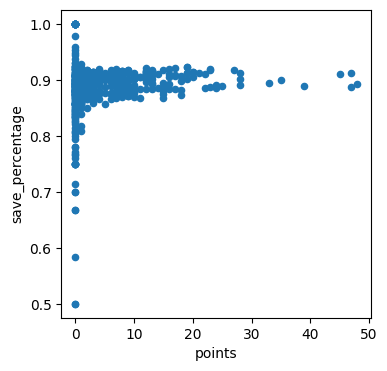

In [ ]:
#Scatter plto
hockey_df
hockey_df.plot.scatter(x='points', y='save_percentage', figsize=(4,4), marker='o')
ax.set_xlabel('Points')
ax.set_ylabel('Save Percentage')
ax.set_title('Points vs Save Percentage')

<Axes: xlabel='points', ylabel='save_percentage'>

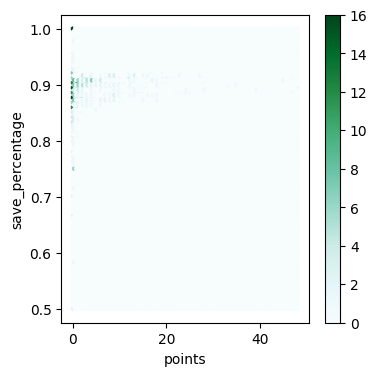

In [ ]:
#gexbin
hockey_df.plot.hexbin(x='points', y='save_percentage', figsize=(4,4))


In [ ]:
hockey_df.columns

Index(['id', 'year', 'overall_pick', 'team', 'player', 'nationality',
       'position', 'age', 'to_year', 'amateur_team', 'games_played', 'goals',
       'assists', 'points', 'plus_minus', 'penalties_minutes',
       'goalie_games_played', 'goalie_wins', 'goalie_losses',
       'goalie_ties_overtime', 'save_percentage', 'goals_against_average',
       'point_shares'],
      dtype='object')